In [3]:
%load_ext autoreload

%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

2023-06-15 16:35:32.345158: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-15 16:35:32.573003: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-15 16:35:32.574759: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-15 16:35:34.254648: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Load the MNIST dataset distributed with Keras. 

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


In [ ]:
y_test

Filter the dataset to keep just the 3s and 6s,  remove the other classes. At the same time convert the label, `y`, to boolean: `True` for `3` and `False` for 6. 

In [5]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [6]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


An image size of 28x28 is much too large for current quantum computers. Resize the image down to 4x4:

In [7]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

In [9]:
import collections
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)
    
    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Throw out images that match more than one label.
          pass
    
    num_uniq_3 = sum(1 for value in mapping.values() if len(value) == 1 and True in value)
    num_uniq_6 = sum(1 for value in mapping.values() if len(value) == 1 and False in value)
    num_uniq_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of unique 3s: ", num_uniq_3)
    print("Number of unique 6s: ", num_uniq_6)
    print("Number of unique contradicting labels (both 3 and 6): ", num_uniq_both)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))
    
    return np.array(new_x), np.array(new_y)

In [10]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

Number of unique images: 10387
Number of unique 3s:  4912
Number of unique 6s:  5426
Number of unique contradicting labels (both 3 and 6):  49

Initial number of images:  12049
Remaining non-contradicting unique images:  10338


In [57]:
batch_size = 10

test_ds = tf.data.Dataset.from_tensor_slices((x_test_small, y_test)).batch(batch_size)
train_ds = tf.data.Dataset.from_tensor_slices((x_train_nocon, y_train_nocon)).batch(batch_size)

## Preparation.

In [58]:
# test run

img1, labels = next(iter(train_ds))
img2, labels = next(iter(test_ds))

2023-06-15 17:11:15.581637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype bool and shape [10338]
	 [[{{node Placeholder/_1}}]]
2023-06-15 17:11:15.588475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype bool and shape [1968]
	 [[{{node Placeholder/_1}}]]


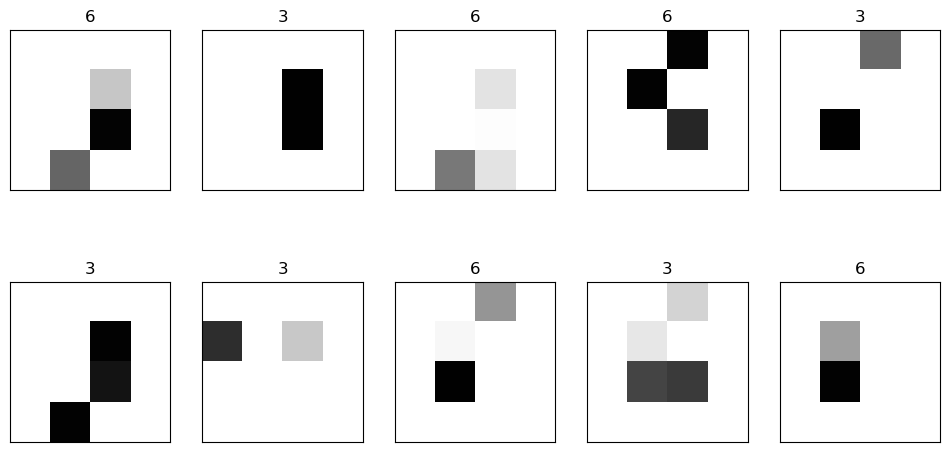

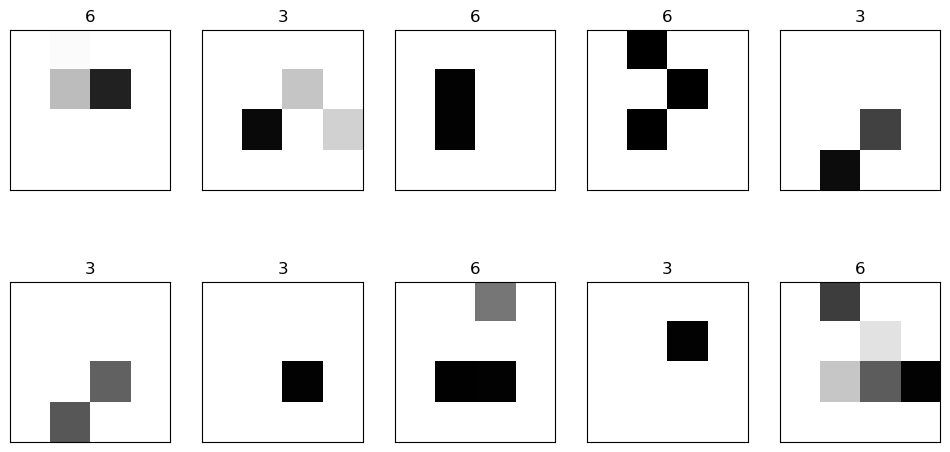

In [59]:
for img in [img1, img2]:
    plt.figure(figsize=(12, 6))
    # assert(batch_size == 10)
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.title("3" if labels[i] else "6")
        plot = plt.imshow(img[i], cmap='Greys', vmin=0, vmax=1)
        # plt.axis("off")
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
        # ax.get_yaxis().set_visible(False)
    plt.show()


In [60]:
batch_size = 100

test_ds = tf.data.Dataset.from_tensor_slices((x_test_small, y_test)).batch(batch_size)
train_ds = tf.data.Dataset.from_tensor_slices((x_train_nocon, y_train_nocon)).batch(batch_size)

# Define model, loss, accuracy

In [61]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [62]:
# accuracy_fn = tf.metrics.Accuracy()
def accuracy_fn(y_true, predicted_logits):
    matches = y_true == (predicted_logits > 0)
    return tf.reduce_mean(tf.cast(matches, tf.float32))

In [63]:
n = 10
m = 1

from model import CRNN
model = CRNN(n, m)


## Learning

In [64]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
epochs = 50


Уменьшаю количество рекуррентных шагов сети

In [84]:
n = 10
m = 2
from model import CRNN
model = CRNN(n, m)


In [85]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
epochs = 12


In [89]:
hist = {"train_loss":[], "test_loss":[], "train_accuracy":[], "test_accuracy":[], "train_batch_loss":[], "test_batch_loss":[]}
from tqdm.notebook import tqdm

pbar = tqdm(range(epochs))
for epoch in pbar:
    processed = 0
    hist["train_loss"].append(0)
    hist["train_accuracy"].append(0)
    for x, y in train_ds:
        with tf.GradientTape() as tape:
            predictions = model.process_img(x)
            loss = loss_fn(y, predictions)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip([tf.clip_by_value(g, clip_value_min=-1, clip_value_max=1) for g in gradients], model.trainable_variables))
        acc = accuracy_fn(y, predictions)
        processed += y.shape[0]
        hist["train_loss"][-1] += loss
        hist["train_batch_loss"].append(loss)
        hist["train_accuracy"][-1] += acc*y.shape[0]
        pbar.set_description(f"Current loss: {loss/y.shape[0]:10.3f}  :::: "+
                            f"Current accuracy:\t {acc:.3f}")
        
    hist["train_loss"][-1] /= processed
    hist["train_accuracy"][-1] /= processed
    
    processed = 0
    hist["test_loss"].append(0)
    hist["test_accuracy"].append(0)
    for x, y in test_ds:
        predictions = model.process_img(x)
        loss = loss_fn(y, predictions)
        acc = accuracy_fn(y, predictions)
        processed += y.shape[0]
        hist["test_loss"][-1] += loss
        hist["test_batch_loss"].append(loss)
        hist["test_accuracy"][-1] += acc*y.shape[0]
        pbar.set_description(f"Current loss: {loss/y.shape[0]}  :::: "+
                            f"Current accuracy:\t {acc:.3f}")
        
    hist["test_loss"][-1] /= processed
    hist["test_accuracy"][-1] /= processed
    
    
    

  0%|          | 0/12 [00:00<?, ?it/s]

KeyboardInterrupt: 

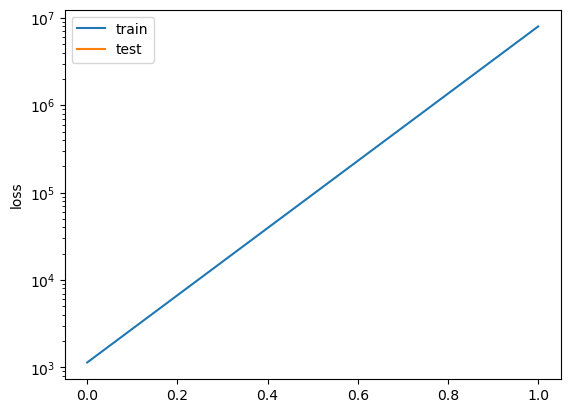

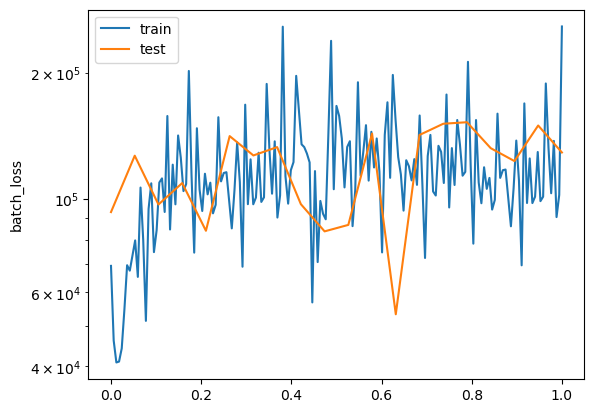

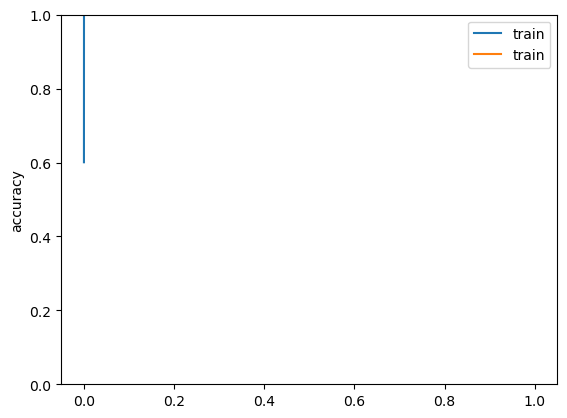

In [90]:
plt.plot(hist["train_loss"], label="train")
plt.plot(hist["test_loss"], label="test")
plt.ylabel("loss")
plt.yscale("log")
plt.legend()
plt.show()

plt.ylabel("batch_loss")
x = np.linspace(0, 1, len(hist["train_batch_loss"]))
plt.plot(x, hist["train_batch_loss"], label="train")
x = np.linspace(0, 1, len(hist["test_batch_loss"]))
plt.plot(x, hist["test_batch_loss"], label="test")
plt.yscale("log")
plt.legend()
plt.show()

plt.ylabel("accuracy")
plt.plot(hist["train_accuracy"], label="train")
plt.plot(hist["test_accuracy"], label="train")
plt.ylim(0, 1)
plt.legend()
plt.show()




In [82]:
print("Final test accuracy: \t", hist["test_accuracy"][-1].numpy())
print("Final train accuracy: \t", hist["train_accuracy"][-1].numpy())

Final test accuracy: 	 0.94512194
Final train accuracy: 	 0.9421552


In [1]:
import tensorflow as tf

# Создание входной матрицы
x = tf.constant([[1.0, 2.0], [3.0, 4.0]])

# Вычисление обратной матрицы
inv_x = tf.linalg.inv(x)

# Вычисление градиента результата по входной матрице
grads = tf.gradients(inv_x, x)

with tf.Session() as sess:
    result, gradient = sess.run([inv_x, grads])
    print("Inverse matrix:")
    print(result)
    print("Gradient:")
    print(gradient)

2023-06-16 13:25:13.609124: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-16 13:25:13.848429: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-16 13:25:13.849927: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-16 13:25:15.174569: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


RuntimeError: tf.gradients is not supported when eager execution is enabled. Use tf.GradientTape instead.

In [4]:
import tensorflow as tf

# Создание входной матрицы
x = tf.constant([[1.0, 2.0], [3.0, 4.0]])

# Создание объекта tf.GradientTape
with tf.GradientTape() as tape:
    # Отслеживание операции вычисления обратной матрицы
    tape.watch(x)
    inv_x = tf.linalg.inv(x)

# Вычисление градиента результата по входной матрице
grads = tape.gradient(inv_x, x)
# Создание объекта tf.GradientTape
with tf.GradientTape() as tape:
    # Отслеживание операции вычисления обратной матрицы
    tape.watch(x)
    inv_x = tf.linalg.inv(x)

jacobian = tape.jacobian(inv_x, x)

print("Inverse matrix:")
print(inv_x)
print("Gradient:")
print(grads)
print("Jacobian:")
print(jacobian)

Inverse matrix:
tf.Tensor(
[[-2.0000002   1.0000001 ]
 [ 1.5000001  -0.50000006]], shape=(2, 2), dtype=float32)
Gradient:
tf.Tensor(
[[-0.5000001   0.5000001 ]
 [ 0.5000001  -0.50000006]], shape=(2, 2), dtype=float32)
Jacobian:
tf.Tensor(
[[[[-4.000001    3.0000007 ]
   [ 2.0000005  -1.5000004 ]]

  [[ 2.0000005  -1.0000002 ]
   [-1.0000002   0.5000001 ]]]


 [[[ 3.0000007  -2.2500005 ]
   [-1.0000002   0.7500002 ]]

  [[-1.5000004   0.7500002 ]
   [ 0.5000001  -0.25000006]]]], shape=(2, 2, 2, 2), dtype=float32)
